# Milestone 1

Team Name: Cloud 9
    
Team members:
- Chad Neald
    - Windows10, 8GB memory, Dual cores i5
- Elina Lin
    - macOs, 16 GB memory, Quad cores i5
- Jordan Lau
    - macOS, 8GB memory, Dual Core i5
- Rafael Pilliard Hellwig
    - macOS, 32GB memory, 6x core i9

> Attribution: Many parts of this assignment are adapted from code authored by Gittu George in his DSCI 525 lecture notes.

## Part 0: Housekeeping

A few additional software packages are required in addition to those from the course conda environment:

In [1]:
%conda install altair r-tidyverse -y

Solving environment: done

## Package Plan ##

  environment location: /Users/raf/opt/miniconda3/envs/525

  added / updated specs:
    - altair
    - r-tidyverse


The following NEW packages will be INSTALLED:

  altair             conda-forge/noarch::altair-4.1.0-py_1
  attrs              conda-forge/noarch::attrs-20.3.0-pyhd3deb0d_0
  entrypoints        conda-forge/noarch::entrypoints-0.3-pyhd8ed1ab_1003
  importlib-metadata conda-forge/osx-64::importlib-metadata-3.10.0-py39h6e9494a_0
  jsonschema         conda-forge/noarch::jsonschema-3.2.0-pyhd8ed1ab_3
  pandoc             conda-forge/osx-64::pandoc-2.13-h0d85af4_0
  pyrsistent         conda-forge/osx-64::pyrsistent-0.17.3-py39hcbf5805_2
  r-askpass          conda-forge/osx-64::r-askpass-1.1-r40h17f1fa6_2
  r-base64enc        conda-forge/osx-64::r-base64enc-0.1_3-r40h17f1fa6_1004
  r-blob             conda-forge/noarch::r-blob-1.2.1-r40h6115d3f_1
  r-brio             conda-forge/osx-64::r-brio-1.1.1-r40h066c5db_0
  r-broom        

Next, we load required modules:

In [1]:
import dask.dataframe as dd
import re
import os
import glob
import sys
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np
from memory_profiler import memory_usage
from os import listdir

import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pyarrow.feather as feather
import rpy2_arrow.pyarrow_rarrow as pyra
import altair as alt

In [2]:
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype');

In [3]:
%load_ext memory_profiler

## Part 1: Team-work contract

The team contract can be found in Canvas.

## Part 2: Creating repository and project structure

The repo structure can be found in the main branch of [UBC-MDS/cloud9](https://github.com/UBC-MDS/cloud9)

```bash
(525) raf@POSEIDON (main) $ tree . -L 2

.
├── LICENSE
├── README.md
├── figshareairline
└── notebook
    ├── Untitled.ipynb
    ├── combo_data.parquet
    ├── combo_data.parquet2
    ├── combo_data2.parquet
    ├── figshareairline
    ├── method1.ipynb
    ├── method2.ipynb
    ├── method3.ipynb
    ├── method4.ipynb
    ├── method5.ipynb
    ├── method6.ipynb
    ├── method7.ipynb
    ├── notebook.ipynb
    ├── notebook2.ipynb
    └── section6.ipynb
```


Our team decided to try different data-loading methods in separate notebooks, so that each method could be run in full isolation in its own kernel. This would also allow team members to attempt to run an entire method, without a notebook potentially crashing before getting to methods further down in the analytical workflow.

## Part 3: Downloading the data

For this assignment, we will use Tomas Beuzen's [_Daily rainfall over NSW_](https://figshare.com/articles/dataset/Daily_rainfall_over_NSW_Australia/14096681/3) data. .

We'll save all our data--raw and intermediary-- to the following directory:

In [4]:
output_directory = "figshareairline/"

Since there are multiple files in the figshare repo, we will download this programatically

In [6]:
# Create a dictionary of files on Tom's figshare repo, along with metadata
article_id = 14096681
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}

response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)
files = data["files"]

We start by making a directory, if needed:

In [12]:
os.makedirs(output_directory, exist_ok=True)

Next, we specify that of the multiple files in the figshare repo, that we only wish to download the `data.zip` file:

In [13]:
files_to_dl = ["data.zip"]

Finally, we download the file:

In [14]:
# download missing files
for item in filter(lambda x: x['name'] in files_to_dl, files):
    filename = os.path.join(output_directory, item["name"])
    if not os.path.isfile(filename):
        urlretrieve(item["download_url"], filename)

In part 4, we are reading in the data directly from the zip file, so no ZIP extraction is necessary as this would needlessly take up disk space. Since some of our team mates were short on available disk space, we chose not to run this. 

However, if we wanted to achieve this, we would run the following code:

In [25]:
# this block gets skipped
if False:
    with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
        f.extractall(output_directory)

This method of extracting the CSV is used in other notebooks listed in part 4.

## Part 4: Combining data CSVs

In this step, we will combine the 27 CSV files in the `data.zip` into one large CSV file that we will write to disk. As per Tom Beuzen's guidance on Slack forums, we are excluding the file `observed_daily_rainfall_SYD.csv` from this analysis.

Our team attempted 7 different approaches to loading the data into memory:

- [Method 1](https://github.com/UBC-MDS/cloud9/blob/main/notebook/method1.ipynb): Reading-in the CSVs from the zip file directly (no unzipping)]
- [Method 2](https://github.com/UBC-MDS/cloud9/blob/main/notebook/method2.ipynb): Unzipping the file, then reading-in each CSV file (with pd.concat)
- [Method 3](https://github.com/UBC-MDS/cloud9/blob/main/notebook/method3.ipynb): Unzipping the file, then reading-in each CSV file (with append)
- [Method 4](https://github.com/UBC-MDS/cloud9/blob/main/notebook/method4.ipynb): Change datatypes from float64 to float32
- [Method 5](https://github.com/UBC-MDS/cloud9/blob/main/notebook/method5.ipynb): Select only columns we care about (time, rainfall, and model name)
- [Method 6](https://github.com/UBC-MDS/cloud9/blob/main/notebook/method6.ipynb): Chunking the read step (increments of 1mn rows)
- [Method 7](https://github.com/UBC-MDS/cloud9/blob/main/notebook/method7.ipynb): Dask


Each team member attempted these methods:



|                                  | Memory (MiB) | Wall Time (hh:mm:ss) | Memory (MiB) | Wall Time (hh:mm:ss) | Memory (MiB) | Wall Time (hh:mm:ss) | Memory (MiB) | Wall Time (hh:mm:ss) |
| -------------------------------- | ------------ | -------------------- | ------------ | -------------------- | ------------ | -------------------- | ------------ | -------------------- |
|                                  | Chad   |         Chad                   | Elina      |      Elina    | Jordan      |      Jordan              | Raf    |             Raf           |
| Method 1 - Pandas on zip         | 4937.63      | 00:06:26             | 6074.06      | 00:01:08             | 2728.92      | 1min 31s             | 10,824       | 00:01:14             |
| Method 2 - Pandas on unzipped    | 5665.94      | 00:10:40             | 6491.25      | 00:00:58             | 3376.7       | 1min 34s             | 9,747        | 00:01:00             |
| Method 3 - Append                | CRASHED      | CRASHED              | 9049.7       | 00:02:32             | 4713.11      | 5min 1s              | 12,652       | 00:02:54             |
| Method 4 - Change dtypes         | 3908.91      | 00:03:28             | 4346.09      | 00:00:57             | 3930.02      | 1min 14s             | 6,418        | 00:01:09             |
| Method 5 - Selective columns     | 2672.21      | 00:02:54             | 4007.17      | 00:00:45             | 2667.77      | 59.8 s               | 4,694        | 00:00:52             |
| Method 6 - Chunking (1e6)        | 3279.76      | 00:03:24             | 3311.48      | 00:01:31             | 3163.36      | 1min 47s             | 12,239       | 00:01:50             |
| Method 7 - Dask (data load only) | 4.35         | 00:00:03             | 9.86         | 00:00:01             | 9.6          | 1.36 s               | 7            | 00:00:01             |





We can see some wildly different results. In particular, it seems that on Raf's machine-- which had ample memory and processing power-- the memory requirements were very large and unpredictable. We hypothesize that this might be because the computer is not necessarily trying to optimize or swap memory if there memory pressure is low.

In terms of winning strategies, selective columns looks like it worked well, but naturally causes loss of information prior to EDA. Dask was amazingly quick to load-- but writing it to parquet for subsequent use in R proved difficult. Going from Dask to CSV took just as long as looping and using traditional pandas approaches. To our knowledge, Dask cannot connect to individual files in a zip without first unzipping them.

TODO: CHECK THAT

Although all team members had sufficient disk space to complete the above methods, some team members ran out of disk space when trying to write the object from memory back to a combo CSV (require approx 6 GB). In the end, since everyone had decent results using **Method 1**, we decided to use this approach to read the data into memory to avoid making copies of files. Additionally, in order to write a combination CSV file to disk, we decided to use pandas' _append_ mode of writing to disk, so that only a single CSV is held in memory at a given time while we build the combo CSV. Together, these two approaches allowed us to keep the disk space requirement low.

Let's run the chosen approach:

In [ ]:
# open a read-only connection to zip file
zfile = zipfile.ZipFile(glob.glob(output_directory + "*.zip")[0], "r")

# list non-hidden files in zip
z_csvs = list(filter(lambda x: not x.startswith("__"), zfile.namelist()))
z_csvs = [x for x in z_csvs if "observed" not in x]

In [6]:
%%time
%%memit

# write to CSV
combo_file = output_directory + "combo_data.csv"
if not os.path.isfile(combo_file):
    # write an empty dataframe to CSV
    cols = ["model", "time", "lat_min", "lat_max", "lon_min", "lon_max", "rain (mm/day)"]
    pd.DataFrame(columns=cols).to_csv(combo_file)

    # populate the combo file with ZIP contents
    for csv in z_csvs:
        df = pd.read_csv(zfile.open(csv))
        df["model"] = csv.split('_daily')[0]
        df[cols].to_csv(combo_file, mode='a', header=False)
        del df

peak memory: 279.47 MiB, increment: 0.05 MiB
CPU times: user 54.6 ms, sys: 47.1 ms, total: 102 ms
Wall time: 3.83 s


On Raf's computer, this step takes about 8 minutes and 30 seconds (the timing above may not apply if the combo data file already is present on disk).

## Part 5: Load the combined CSV to memory and perform a simple EDA

The above cell takes 8 min 30s on Raf's computer.

### Option 5.1: Selective selection of columns with float32

In [10]:
%%time
%%memit

# define the dtypes
colspec = {"time": "str",
           "lat_min": np.float32,
           "lat_max": np.float32,
           "lon_min": np.float32,
           "lon_max": np.float32,
           "rain (mm/day)": np.float32}

# select cols
usecols = ["model", "time", "rain (mm/day)"]

# read-in the combo file
dat = pd.read_csv(combo_file, dtype=colspec, parse_dates=["time"], usecols=usecols)

peak memory: 4826.23 MiB, increment: 4534.57 MiB
CPU times: user 54.6 s, sys: 4.29 s, total: 58.9 s
Wall time: 1min


Our team was not sure if it was necessary to specify `float32` types for columns being discarded, be we figured it would do any harm.

### Option 5.2: Dask

Our next option is reading-in the combined file using dask:

In [11]:
%%time
%%memit

# read-in with dask
dat = dd.read_csv(combo_file)

peak memory: 3434.07 MiB, increment: 0.50 MiB
CPU times: user 187 ms, sys: 220 ms, total: 407 ms
Wall time: 1.39 s


From the profiling, it is apparent that Dask has a negligible memory footprint.

In [12]:

dat.head()

,model,time,lat_min,lat_max,lon_min,lon_min.1,rain (mm/day)
0,MPI-ESM-1-2-HAM,1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,141.5625,4.244226e-13
1,MPI-ESM-1-2-HAM,1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,141.5625,4.217326e-13
2,MPI-ESM-1-2-HAM,1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,141.5625,4.498125e-13
3,MPI-ESM-1-2-HAM,1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,141.5625,4.251282e-13
4,MPI-ESM-1-2-HAM,1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,141.5625,4.270161e-13


In [17]:
%%time
%%memit

print(dat.shape[0].compute())

62467843
peak memory: 6546.75 MiB, increment: 2647.23 MiB
CPU times: user 1min 27s, sys: 18.6 s, total: 1min 46s
Wall time: 35.6 s


We can see that a 'simple' operation of counting the number of rows took much longer than the near-instantaneous `.shape` attribute we are accustomed to with the usual pandas DataFrames.

Let's try a more realistic EDA scenario, where we would want to look at average rainfall by model:

In [14]:
%%time
%%memit

res = (dat
       .groupby('model')['rain (mm/day)']
       .agg(["mean", "std"])
       .sort_values("mean")
       .reset_index()
       .compute()
      )
print(res)

               model      mean       std
0      MPI-ESM1-2-HR  0.995569  4.083814
1      MPI-ESM1-2-LR  1.074308  3.911700
2          KIOST-ESM  1.102353  3.852051
3         MRI-ESM2-0  1.368030  4.517987
4           GFDL-CM4  1.414485  5.024926
5   EC-Earth3-Veg-LR  1.516258  4.714335
6    MPI-ESM-1-2-HAM  1.610720  4.885519
7              NESM3  1.621936  4.971972
8        FGOALS-f3-L  1.627373  5.747396
9         ACCESS-CM2  1.787025  5.914188
10          BCC-ESM1  1.811032  5.358361
11           CanESM5  1.894328  5.835787
12       BCC-CSM2-MR  1.951832  6.200969
13    AWI-ESM-1-1-LR  2.026071  5.321889
14         FGOALS-g3  2.156419  6.015488
15       SAM0-UNICON  2.169676  6.383241
16     ACCESS-ESM1-5  2.217501  6.422397
17           TaiESM1  2.224576  5.886578
18        NorESM2-LM  2.230799  5.681562
19        NorESM2-MM  2.232966  6.151688
20         CMCC-ESM2  2.266125  5.538429
21      CMCC-CM2-HR4  2.279350  5.629965
22            MIROC6  2.301662  6.393745
23      CMCC-CM2

Calculating model-wise summaries also took a long time-- almost a minute! However, the memory usage was reasonable, at 431 MiB.

Let's plot this result:

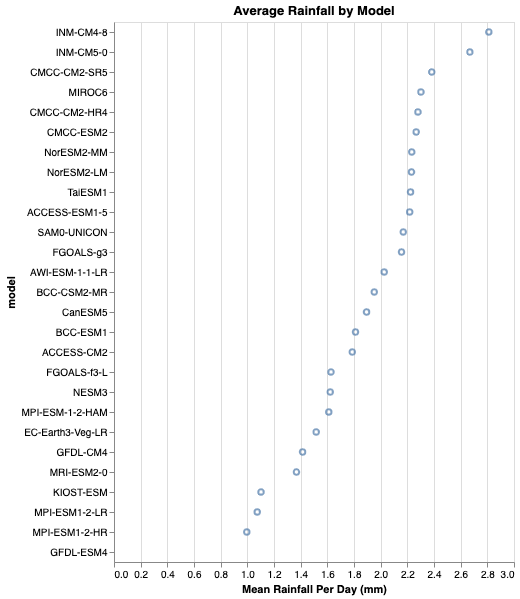

In [19]:
base = alt.Chart(res, title = "Average Rainfall by Model")
points = base.mark_point().encode(
    alt.Y("model:N", sort="-x"),
    alt.X("mean:Q", title = "Mean Rainfall Per Day (mm)")
)

points

From this simple EDA, we can see that average rainfall ranges from 1 to 2.8 mm/day for the different models. Most models place the mean rain fall somewhere near 1.8-2.0 mm/day.

**Part 5 Summary**:

We can see that Dask is very efficient with regards to reducing memory requirements. However, the prices for this are queries that are much slower to run. In contrast, the modified pandas approaches (selective columns, float32) is memory-hungry, but conducts queries quickly provided the machine has enough memory.

## Part 6: Perform a simple EDA in R

The first step is to transfer the data from the Python kernel to the R kernel:

In [20]:
%load_ext rpy2.ipython

In [ ]:
%%R

library(tidyverse)

### Option 6.1: Pandas Exchange

Unfortunately, Pandas exchange is a terribly slow solution for transferring data. On the computer with the best resources this took 39 minutes:

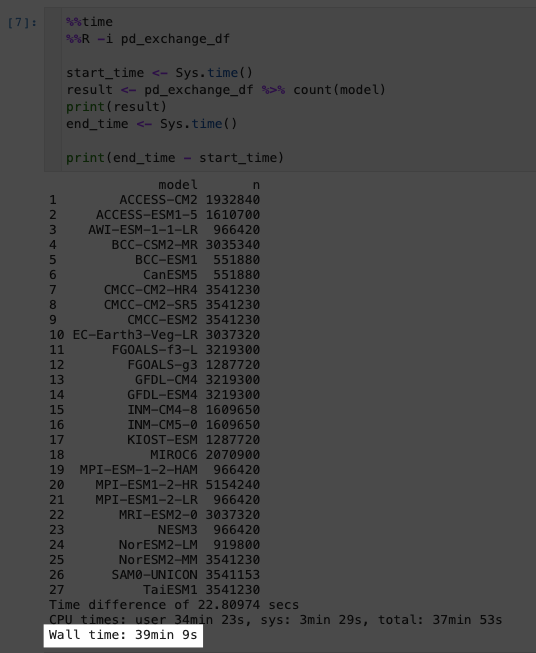

### Option 6.2: Arrow Exchange

Arrow exchange can be a bit temperamental. For example, we discovered that `ds.dataset()` did not work if the CSV file was saved to disk with the index, since this would result the first column header being unnamed. 

In [16]:
%%time
%%memit

dataset = ds.dataset("figshareairline/combo_data.csv", format="csv")
table = dataset.to_table()
r_table = pyra.converter.py2rpy(table)

5673
rarrow.ChunkedArray: 0.028639554977416992
5673
rarrow.ChunkedArray: 0.028110980987548828
5673
rarrow.ChunkedArray: 0.025722026824951172
5673
rarrow.ChunkedArray: 0.03169393539428711
5673
rarrow.ChunkedArray: 0.02588486671447754
5673
rarrow.ChunkedArray: 0.02441692352294922
5673
rarrow.ChunkedArray: 0.023591041564941406
peak memory: 3174.38 MiB, increment: 2941.07 MiB
CPU times: user 50.1 s, sys: 14.4 s, total: 1min 4s
Wall time: 1min 1s


In [20]:
%%time
%%R -i r_table

start_time <- Sys.time()
result <- r_table %>% collect() %>% count(model)
end_time <- Sys.time()
print(result)

print(end_time - start_time)

# A tibble: 27 x 2
   model                  n
   <chr>              <int>
 1 ACCESS-CM2       1932840
 2 ACCESS-ESM1-5    1610700
 3 AWI-ESM-1-1-LR    966420
 4 BCC-CSM2-MR      3035340
 5 BCC-ESM1          551880
 6 CanESM5           551880
 7 CMCC-CM2-HR4     3541230
 8 CMCC-CM2-SR5     3541230
 9 CMCC-ESM2        3541230
10 EC-Earth3-Veg-LR 3037320
# … with 17 more rows
Time difference of 11.7424 secs
CPU times: user 9.26 s, sys: 14.9 s, total: 24.1 s
Wall time: 11.8 s


### Option 6.3: Feather

In [24]:
%%time
%%memit

feather.write_feather(table, 'figshareairline/final.feather')

peak memory: 8284.61 MiB, increment: 103.29 MiB
CPU times: user 4.1 s, sys: 8.11 s, total: 12.2 s
Wall time: 8.46 s


In [26]:
%%time
%%R

start_time <- Sys.time()
ft_df <- arrow::read_feather("figshareairline/final.feather",
                             col_select = c("time", "rain (mm/day)", "model"))
result <- ft_df %>% count(model)
end_time <- Sys.time()

print(result)

print(end_time - start_time)

# A tibble: 27 x 2
   model                  n
   <chr>              <int>
 1 ACCESS-CM2       1932840
 2 ACCESS-ESM1-5    1610700
 3 AWI-ESM-1-1-LR    966420
 4 BCC-CSM2-MR      3035340
 5 BCC-ESM1          551880
 6 CanESM5           551880
 7 CMCC-CM2-HR4     3541230
 8 CMCC-CM2-SR5     3541230
 9 CMCC-ESM2        3541230
10 EC-Earth3-Veg-LR 3037320
# … with 17 more rows
Time difference of 12.77123 secs
CPU times: user 7.55 s, sys: 6.57 s, total: 14.1 s
Wall time: 12.8 s


In [30]:
%%sh
du -sh figshareairline/final.feather

1.0G	figshareairline/final.feather


Combined, this implies roughly 18 seconds to transfer and analyse the data with feather.

### Option 6.4: Parquet

In [28]:
type(table)

pyarrow.lib.Table

### Option 6.5: CSV via Disk

Finally, we wanted to check how long it would take to simply transfer the data between Python and R via a CSV file directly. Since we already saw above that it took 8 min 30 seconds to write the combination file to disk, the only thing missing for us to measure is the time/memory needed to read that CSV to R natively:

In [21]:
%%R

system.time({
    colspec = cols(
          model = col_character(),
          time = col_datetime(format = ""),
          lat_min = col_double(),
          lat_max = col_double(),
          lon_min = col_double(),
          lon_min.1 = col_double(),
          `rain (mm/day)` = col_double()
        )
    df <- readr::read_csv('figshareairline/combo_data.csv', col_types = colspec)
})


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  model = col_character(),
  time = col_datetime(format = ""),
  lat_min = col_double(),
  lat_max = col_double(),
  lon_min = col_double(),
  lon_min.1 = col_double(),
  `rain (mm/day)` = col_double()
)

|=================================================================| 100% 5672 MB
   user  system elapsed 
158.161  27.207 166.103 


**Write from a pyarrow table to parquet:**

In [26]:
%%time
%%memit
## writing as a single parquet
pq.write_table(table, 'figshareairline/final.parquet')

peak memory: 10032.45 MiB, increment: 134.91 MiB
CPU times: user 11.2 s, sys: 2.21 s, total: 13.4 s
Wall time: 14.6 s


**Read from parquet:**

In [32]:
%%time
%%R
start_time <- Sys.time()
pq_df <- arrow::read_parquet("figshareairline/final.parquet", col_select = c("time", "rain (mm/day)", "model"))
result <- pq_df %>% count(model)
end_time <- Sys.time()
print(result)

print(end_time - start_time)

# A tibble: 27 x 2
   model                  n
   <chr>              <int>
 1 ACCESS-CM2       1932840
 2 ACCESS-ESM1-5    1610700
 3 AWI-ESM-1-1-LR    966420
 4 BCC-CSM2-MR      3035340
 5 BCC-ESM1          551880
 6 CanESM5           551880
 7 CMCC-CM2-HR4     3541230
 8 CMCC-CM2-SR5     3541230
 9 CMCC-ESM2        3541230
10 EC-Earth3-Veg-LR 3037320
# … with 17 more rows
Time difference of 10.2242 secs
CPU times: user 9.34 s, sys: 4.81 s, total: 14.2 s
Wall time: 10.3 s


In [29]:
%%sh
du -sh figshareairline/final.parquet

544M	figshareairline/final.parquet


Combined, this implies roughly 27 seconds to transfer and analyse the data with parquet.

**Section 6 Summary**

TODO: tidy up

These were some benchmarks run on I/O for a dataset with 5,000 records.

Note, however, that the above were run on Raf's computer, and the results were far worse on other machines.

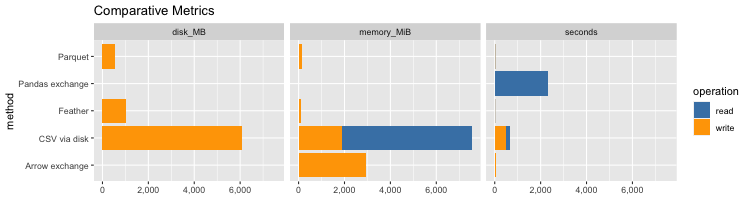

In [24]:
%%R -h 200 -w 750

# on Raf's computer
results <- tribble(
    ~method,           ~operation, ~seconds,  ~memory_MiB, ~disk_MB,
    "CSV via disk",    "write",   8*60 + 30,      1881.55, 5.95*1024,
    "CSV via disk",    "read",          166,         5672,        0,
    "Pandas exchange", "read",        39*60,           NA,        0,
    "Arrow exchange",  "write",          61,      2941.07,        0,
    "Feather",         "write",        8.46,       103.29,     1024,
    "Feather",         "read",          9.3,           NA,        0,
    "Parquet",         "write",        14.6,       134.91,      544,
    "Parquet",         "read",         11.8,           NA,        0)

# Visualize
results %>%
    pivot_longer(cols = c(seconds, memory_MiB, disk_MB)) %>%
    ggplot(aes(x = method, y = value, fill = operation)) +
    geom_col() +
    scale_y_continuous(labels = scales::comma) +
    scale_fill_manual(values = c("steelblue", "orange")) +
    coord_flip() +
    facet_wrap(~name) +
    labs(title = "Comparative Metrics",
         y = NULL)

On the whole, it appears that Parquet and Feather both achieve decent results. The trade-off between the two is that Parquet is more lightweight on disk but requires slightly longer computer time, whereas feather takes roughly double the disk space but runs ~ 30% faster.

Note, since `%%memit` does not work for cells with R magics, the memory comparison may not be entirely fair. As hypothesized above, it is also possible that the memory requirements reported may be higher on machines that have a lot of free memory available (no memory swapping or virtual memory).

And finally, it does appear that pandas exchange is universally bad for large datasets.

One drawback of the above approaches is that we needed to create an intermediary (and heavy) `combo_data.csv`, instead of working directly from separate source files. However, weighting all the benefits and drawbacks, our final choice would be to use Feather.

## References


- Beuzen, Tomas (2021): Daily rainfall over NSW, Australia. figshare. Dataset. https://doi.org/10.6084/m9.figshare.14096681.v3